# Predict Future Sales
The goal of this challenge is to predict the future sales of a company. We need to be able to predict the monthly sales of each shop and for each unique item.
My goal for this challenge wasn't to get the best score, I went through this course mostly to get a better understanding of what the best competitors did in terms of feature engineering and hyperparamater optimization. Thus I tested a lot of different approaches until I finally achieved a RMSE good enough to pass. Some of the snippets are also taken from other people that went over this challenge before me (mostly on Kaggle).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Requirements</a></span></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Exploration</a></span><ul class="toc-item"><li><span><a href="#Missing-combinations" data-toc-modified-id="Missing-combinations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Missing combinations</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Adding-categories" data-toc-modified-id="Adding-categories-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Adding categories</a></span></li><li><span><a href="#Lag-features" data-toc-modified-id="Lag-features-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Lag features</a></span></li><li><span><a href="#Month-feature" data-toc-modified-id="Month-feature-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Month feature</a></span></li></ul></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Data-Split" data-toc-modified-id="Data-Split-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Split</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Feature Importance</a></span></li></ul></li><li><span><a href="#Applying-to-test-set" data-toc-modified-id="Applying-to-test-set-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Applying to test set</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Requirements

The code has been developped & run on Kaggle.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

## Data Exploration

In [2]:
DATA_FOLDER = '/kaggle/input/competitive-data-science-predict-future-sales/'

transactions    = pd.read_csv(DATA_FOLDER + 'sales_train.csv')
items           = pd.read_csv(DATA_FOLDER + 'items.csv')
item_categories = pd.read_csv(DATA_FOLDER + 'item_categories.csv')
shops           = pd.read_csv(DATA_FOLDER + 'shops.csv')
test            = pd.read_csv(DATA_FOLDER + 'test.csv')

In [3]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [4]:
print(item_categories.shape)
item_categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
print(transactions.shape)
transactions.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
transactions['item_cnt_day'].value_counts()[:10]

 1.0     2629372
 2.0      194201
 3.0       47350
 4.0       19685
 5.0       10474
-1.0        7252
 6.0        6338
 7.0        4057
 8.0        2903
 9.0        2177
 10.0       1820
Name: item_cnt_day, dtype: int64

In [9]:
## We're interested in the monthly sales, so we're going to ignore the items returned
transactions.drop(transactions[transactions['item_cnt_day'] == -1.0].index, inplace=True)

For my approach I decided to keep only the shops and items that we were required to predict on the test set. We already have a pretty big dataset, and it will only get bigger as a lot of combinations between shop and item_ids are missing (each item isn't necessarily bought in each shop).

In [132]:
print(transactions.shape)

(2928597, 6)


In [133]:
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = transactions[transactions.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

In [134]:
print(train.shape)

(1221546, 6)


After keeping only the shops and items present in the test we've halfed our transactions dataset, but we still have 1M+ rows.  
We're now going to remove outliers present in our data.

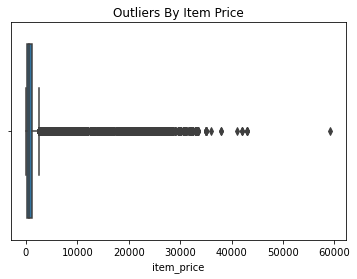

In [135]:
sns.boxplot(x=train.item_price)
plt.title('Outliers By Item Price');

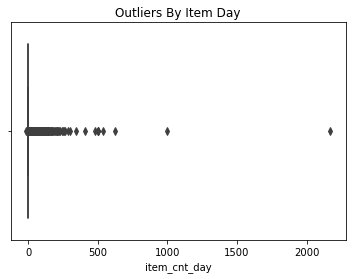

In [136]:
sns.boxplot(x=train.item_cnt_day)
plt.title('Outliers By Item Day');

In [137]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

### Missing combinations
As I said earlier each item isn't necessarily bought in each shop. Moreover, even if an item is sold, he's not necessarily sold every month. Hence we're going to have to add those missing combinations and we'll just fill them with 0 (a missing combination means this item hasn't been sold this month in this shop).  
We're first going to create a grid with all the possible combinations, then group our transaction datframe and merge it with the grid to complete our dataframe with the missing combinations.

In [138]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
print(grid.shape)
grid.head()

(2731538, 3)


,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2574,0
2,59,2607,0
3,59,2614,0
4,59,2808,0


In [139]:
X = train.groupby(['date_block_num','shop_id', 'item_id'], as_index=False).agg({'item_cnt_day': 'sum', 'item_price': 'mean'})
X.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)
print(X.shape)
del train
X.head()

(599915, 5)


,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,2,33,1.0,499.0
1,0,2,482,1.0,3300.0
2,0,2,491,1.0,600.0
3,0,2,839,1.0,3300.0
4,0,2,1007,3.0,449.0


In [140]:
# Merging sales numbers with the grid dataframe
X = pd.merge(grid,X,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

### Feature Engineering  

#### Adding categories

In [141]:
X = pd.merge(X, items.drop('item_name', axis = 1), on=['item_id'], how='left')
X.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id
0,59,22154,0,1.0,999.0,37
1,59,2574,0,2.0,399.0,55
2,59,2607,0,0.0,0.0,55
3,59,2614,0,0.0,0.0,55
4,59,2808,0,15.0,999.0,30


#### Lag features

In [142]:
groupcollist = ['item_id','shop_id','item_category_id']

aggregationlist = [('item_price',np.mean,'avg'),('item_cnt_month',np.sum,'sum'),('item_cnt_month',np.mean,'avg')]

for type_id in groupcollist:
    for column_id,aggregator,aggtype in aggregationlist:
        mean_df = X.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        X = pd.merge(X,mean_df,on=['date_block_num',type_id],how='left')

In [143]:
X.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_month,item_id_avg_item_cnt_month,shop_id_avg_item_price,shop_id_sum_item_cnt_month,shop_id_avg_item_cnt_month,item_category_id_avg_item_price,item_category_id_sum_item_cnt_month,item_category_id_avg_item_cnt_month
0,59,22154,0,1.0,999.0,37,363.272727,16.0,0.484848,143.09915,452.0,0.492912,127.689436,1022.0,0.412929
1,59,2574,0,2.0,399.0,55,277.846061,84.0,2.545455,143.09915,452.0,0.492912,60.580583,3240.0,0.370497
2,59,2607,0,0.0,0.0,55,109.909091,18.0,0.545455,143.09915,452.0,0.492912,60.580583,3240.0,0.370497
3,59,2614,0,0.0,0.0,55,117.787879,16.0,0.484848,143.09915,452.0,0.492912,60.580583,3240.0,0.370497
4,59,2808,0,15.0,999.0,30,987.029809,689.0,20.878788,143.09915,452.0,0.492912,415.672427,3771.0,5.713636


In [144]:
lag_variables  = ['item_id_avg_item_price','item_id_sum_item_cnt_month','item_id_avg_item_cnt_month','shop_id_avg_item_price','shop_id_sum_item_cnt_month','shop_id_avg_item_cnt_month','item_category_id_avg_item_price','item_category_id_sum_item_cnt_month','item_category_id_avg_item_cnt_month','item_cnt_month']
lags = [1 ,2 ,3 ,4, 5, 12]
X_means = X.copy()
for lag in lags:
    X_new_df = X.copy()
    X_new_df.date_block_num+=lag
    X_new_df = X_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    X_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    X_means = pd.merge(X_means, X_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [145]:
for feat in X_means.columns:
    if 'item_cnt' in feat:
        X_means[feat]=X_means[feat].fillna(0)
    elif 'item_price' in feat:
        X_means[feat]=X_means[feat].fillna(X_means[feat].median())

In [146]:
list(X_means.columns)

['shop_id',
 'item_id',
 'date_block_num',
 'item_cnt_month',
 'item_price',
 'item_category_id',
 'item_id_avg_item_price',
 'item_id_sum_item_cnt_month',
 'item_id_avg_item_cnt_month',
 'shop_id_avg_item_price',
 'shop_id_sum_item_cnt_month',
 'shop_id_avg_item_cnt_month',
 'item_category_id_avg_item_price',
 'item_category_id_sum_item_cnt_month',
 'item_category_id_avg_item_cnt_month',
 'item_id_avg_item_price_lag_1',
 'item_id_sum_item_cnt_month_lag_1',
 'item_id_avg_item_cnt_month_lag_1',
 'shop_id_avg_item_price_lag_1',
 'shop_id_sum_item_cnt_month_lag_1',
 'shop_id_avg_item_cnt_month_lag_1',
 'item_category_id_avg_item_price_lag_1',
 'item_category_id_sum_item_cnt_month_lag_1',
 'item_category_id_avg_item_cnt_month_lag_1',
 'item_cnt_month_lag_1',
 'item_id_avg_item_price_lag_2',
 'item_id_sum_item_cnt_month_lag_2',
 'item_id_avg_item_cnt_month_lag_2',
 'shop_id_avg_item_price_lag_2',
 'shop_id_sum_item_cnt_month_lag_2',
 'shop_id_avg_item_cnt_month_lag_2',
 'item_category_id_av

We're going to drop the non-lagged versions of our features to avoid data leakage. We're also going to remove the *item_price* feature as I didn't find an appropriate procedure to fill the NA values, but it was definitely an important feature on some of the models I ran so this would be one way of improvement.

In [147]:
cols_to_drop = lag_variables[:-1] + ['item_price']

for col in cols_to_drop:
    del X_means[col]

In [148]:
# Since we have lagged features that go up to 12 months, we're going to skip the first 12 months of our data.
X_means = X_means[X_means['date_block_num']>11]

#### Month feature  

One thing I did to make the _month_ feature a bit more expressive is to map it to a circle and then compute the sin & cos for each value. It's a process that works great with **cyclical features** such as the month, it allows for the model to understand that January comes after December.

In [151]:
X_means['month'] = X_means['date_block_num'] % 12
X_means.loc[(X_means['date_block_num'] < 12), 'year'] = 0
X_means.loc[(X_means['date_block_num'] < 24) & (X['date_block_num'] > 11), 'year'] = 1
X_means.loc[(X_means['date_block_num'] > 23), 'year'] = 2
X_means['mnth_sin'] = np.sin((X_means.month)*(2.*np.pi/12))
X_means['mnth_cos'] = np.cos((X_means.month)*(2.*np.pi/12))
X_means.drop('month', axis=1, inplace=True)
X_means.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_month_lag_1,item_id_avg_item_cnt_month_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_month_lag_1,...,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_month_lag_12,shop_id_avg_item_cnt_month_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_month_lag_12,item_category_id_avg_item_cnt_month_lag_12,item_cnt_month_lag_12,year,mnth_sin,mnth_cos
506772,55,492,12,123.0,76,15.735027,92.0,2.421053,22.573639,726.0,...,174.628638,0.0,0.0,73.03532,0.0,0.0,0.0,1.0,0.0,1.0
506773,55,504,12,7.0,31,4.605263,1.0,0.026316,22.573639,726.0,...,174.628638,0.0,0.0,73.03532,0.0,0.0,0.0,1.0,0.0,1.0
506774,55,508,12,3.0,31,2.500000,1.0,0.026316,22.573639,726.0,...,174.628638,0.0,0.0,73.03532,0.0,0.0,0.0,1.0,0.0,1.0
506775,55,515,12,6.0,31,3.263158,4.0,0.105263,22.573639,726.0,...,174.628638,0.0,0.0,73.03532,0.0,0.0,0.0,1.0,0.0,1.0
506776,55,539,12,2.0,78,4.526316,1.0,0.026316,22.573639,726.0,...,174.628638,0.0,0.0,73.03532,0.0,0.0,0.0,1.0,0.0,1.0


## Model

### Data Split

Since we're facing a time-series problem and the challenge is to predict only the **next month** I only kept the last month as validation data, the rest was used for training.

In [169]:
X_train = X_means[X_means.date_block_num < 33].drop(['item_cnt_month', 'date_block_num'], axis=1).values
y_train = X_means[X_means.date_block_num < 33].loc[:, 'item_cnt_month'].clip(0,20)

X_test = X_means[X_means.date_block_num == 33].drop(['item_cnt_month', 'date_block_num'], axis=1).values
y_test = X_means[X_means.date_block_num == 33].loc[:, "item_cnt_month"].clip(0,20)

In [170]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2058656, 66) (2058656,) (166110, 66) (166110,)


Even with all the processing we did (selecting only what was in the test, grouping the data, removing the first year etc...) we still end up with a training set with **2M+** rows.

### Training

In [172]:
import xgboost as xgb
xgb = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=1000,
    max_depth=8,
    reg_alpha=0.1,
    reg_lambda=2,
    eta=0.1,
    tree_method='gpu_hist',
    seed=32)

In [173]:
xgb.fit(X_train,y_train,eval_metric="rmse",
        eval_set=[(X_train, y_train) 
                  ,(X_test, y_test)
                 ],
        verbose=False,
        early_stopping_rounds = 10)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=32,
             reg_alpha=0.1, reg_lambda=2, scale_pos_weight=1, seed=32,
             subsample=1, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

In [174]:
from sklearn.metrics import mean_squared_error
preds = xgb.predict(X_test)
print("RMSE = ", mean_squared_error(y_test, preds, squared = False))

RMSE =  0.9527644231045822


In [185]:
## Saving the model
# import pickle
# filename = 'finalized_model.sav'
# pickle.dump(xgb, open(filename, 'wb'))

### Feature Importance

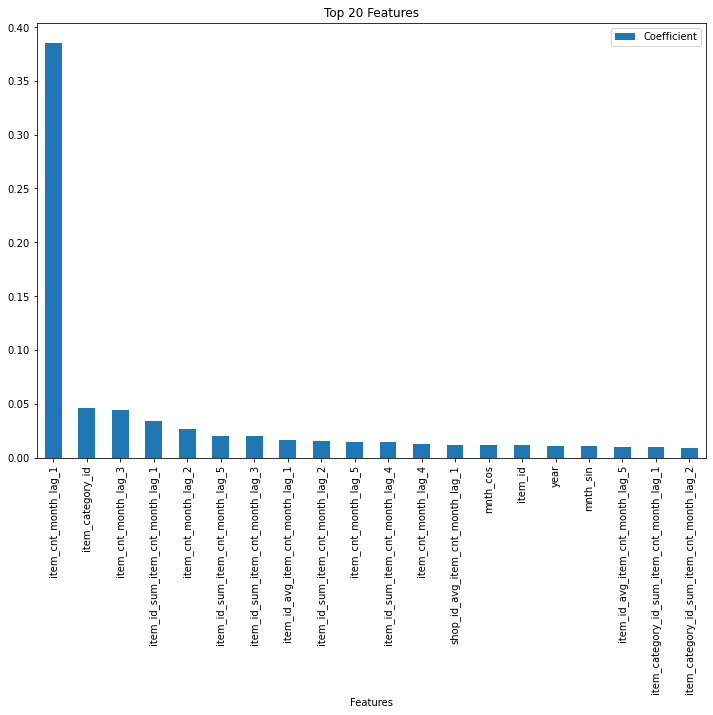

In [176]:
coeff_df = pd.DataFrame(xgb.feature_importances_,list_col,columns=['Coefficient'])

fig, ax = plt.subplots(1,1,figsize=(12,8))
coeff_df.sort_values(by='Coefficient',ascending=False).head(20).plot(kind='bar',ax=ax)
plt.xlabel('Features')
plt.title('Top 20 Features');

## Applying to test set

In [175]:
list_col = X_means.drop(['item_cnt_month', 'date_block_num'], axis=1).columns
list_col

Index(['shop_id', 'item_id', 'item_category_id',
       'item_id_avg_item_price_lag_1', 'item_id_sum_item_cnt_month_lag_1',
       'item_id_avg_item_cnt_month_lag_1', 'shop_id_avg_item_price_lag_1',
       'shop_id_sum_item_cnt_month_lag_1', 'shop_id_avg_item_cnt_month_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_month_lag_1',
       'item_category_id_avg_item_cnt_month_lag_1', 'item_cnt_month_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_month_lag_2',
       'item_id_avg_item_cnt_month_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_month_lag_2', 'shop_id_avg_item_cnt_month_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_month_lag_2',
       'item_category_id_avg_item_cnt_month_lag_2', 'item_cnt_month_lag_2',
       'item_id_avg_item_price_lag_3', 'item_id_sum_item_cnt_month_lag_3',
       'item_id_avg_item_cnt_month_lag_3', 'shop_id_avg_item_price

In [177]:
test = pd.read_csv(DATA_FOLDER + 'test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [178]:
test = pd.merge(test, items.drop('item_name', axis = 1), on=['item_id'], how='left')
test['date_block_num'] = 34
test.head()

,ID,shop_id,item_id,item_category_id,date_block_num
0,0,5,5037,19,34
1,1,5,5320,55,34
2,2,5,5233,19,34
3,3,5,5232,23,34
4,4,5,5268,20,34


In [179]:
lag_variables  = ['item_id_avg_item_price','item_id_sum_item_cnt_month','item_id_avg_item_cnt_month','shop_id_avg_item_price','shop_id_sum_item_cnt_month','shop_id_avg_item_cnt_month','item_category_id_avg_item_price','item_category_id_sum_item_cnt_month','item_category_id_avg_item_cnt_month','item_cnt_month']
lags = [1 ,2 ,3 ,4, 5, 12]
for lag in lags:
    X_new_df = X.copy()
    X_new_df.date_block_num+=lag
    # subset only the lag variables we want
    X_new_df = X_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    X_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    # join with date_block_num,shop_id and item_id
    test = pd.merge(test, X_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [80]:
test.columns

Index(['ID', 'shop_id', 'item_id', 'item_category_id', 'date_block_num',
       'item_id_avg_item_price_lag_1', 'item_id_sum_item_cnt_month_lag_1',
       'item_id_avg_item_cnt_month_lag_1', 'shop_id_avg_item_price_lag_1',
       'shop_id_sum_item_cnt_month_lag_1', 'shop_id_avg_item_cnt_month_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_month_lag_1',
       'item_category_id_avg_item_cnt_month_lag_1', 'item_cnt_month_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_month_lag_2',
       'item_id_avg_item_cnt_month_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_month_lag_2', 'shop_id_avg_item_cnt_month_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_month_lag_2',
       'item_category_id_avg_item_cnt_month_lag_2', 'item_cnt_month_lag_2',
       'item_id_avg_item_price_lag_3', 'item_id_sum_item_cnt_month_lag_3',
       'item_id_avg_item_cnt_month_lag_3',

In [181]:
test['mnth_sin'] = np.sin((11-1)*(2.*np.pi/12))
test['mnth_cos'] = np.cos((11-1)*(2.*np.pi/12))
test['year'] = 2
for feat in test.columns:
    if 'item_cnt' in feat:
        test[feat]=test[feat].fillna(0)
    elif 'item_price' in feat:
        test[feat]=test[feat].fillna(X_means[feat].median())

In [182]:
print(test[list_col].shape)

(214200, 66)


In [183]:
test = test[list_col]
test_preds = xgb.predict(test.values)
submission = pd.DataFrame(pd.read_csv(DATA_FOLDER + 'test.csv')['ID'], columns=['ID'])
submission['item_cnt_month'] = test_preds
print(submission.shape)
submission.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.595010
1,1,0.383615
2,2,0.793582
3,3,0.430493
4,4,4.061564


In [184]:
submission.to_csv('submission.csv', index = None, header=True)

## Conclusion  

With that approach I was able to score an RMSE of **0.94** on both public and private set.  

I want to emphasize the fact that this notebook only contains the code that made it possible to pass the assignment. It doesn't cover my previous approaches such as : 
- Hyperparamater Tuning.
- Using all possible shops&items (not restricting to the test set).
- Not filling the missing months (where an item hasn't been sold).
- Using *item_price*.
- Random Forest
- LSTM  
  
This challenge was interesting as it reaffirms how important feature engineering is. I was also pretty impressed of how clipping the target value could improve the results so much. At first I didn't clip the target variable and achieved much more higher RMSE and it drastically dropped once I clipped the target.